# Extract and save features

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import requests
from tensorflow.keras.models import load_model, Model
from sklearn.preprocessing import LabelEncoder
import pickle

# Load your model and label encoder
model = load_model("/kaggle/input/fashion-dm/fashion_classifier2.h5")

# Create embedding model
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Load your full dataset
df = pd.read_csv("/kaggle/input/fashion-dm/Finaldataa1.csv")
label_encoder = LabelEncoder()
df["category"] = label_encoder.fit_transform(df["category"])


with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


def preprocess_image(url, img_size=(224, 224)):
    try:
        if url.startswith("//"):
            url = "https:" + url
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", img_size, (255, 255, 255))
    img = img.resize(img_size)
    img = np.array(img) / 255.0
    return np.expand_dims(img, axis=0)

# Extract and store features
features = []
valid_rows = []

for idx, row in df.iterrows():
    url = row["p_img"]
    img_array = preprocess_image(url)
    embedding = embedding_model.predict(img_array, verbose=0)[0]
    features.append(embedding)
    valid_rows.append(row)


features_array = np.array(features)
meta_df = pd.DataFrame(valid_rows).reset_index(drop=True)

# Save features and metadata
np.save("image_embeddings.npy", features_array)
meta_df.to_csv("image_metadata.csv", index=False)

print("✅ Feature extraction saved: image_embeddings.npy and image_metadata.csv")


I0000 00:00:1744562053.265398      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744562053.266129      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1744562060.172766      99 service.cc:148] XLA service 0x7a7bf0003ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744562060.173495      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744562060.173524      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744562061.035496      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744562065.077282      99 device_compiler.h:188] Compiled clust

✅ Feature extraction saved: image_embeddings.npy and image_metadata.csv


# find similar items

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model, Model

# Load saved data
features_array = np.load("/kaggle/working/image_embeddings.npy")
meta_df = pd.read_csv("/kaggle/working/image_metadata.csv")

# Load model + embedding model
model = load_model("/kaggle/input/fashion-dm/fashion_classifier2.h5")
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Load label encoder
with open("/kaggle/working/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Preprocess user query and find similar items
def preprocess_image(url, img_size=(224, 224)):
    from PIL import Image
    from io import BytesIO
    import requests

    try:
        if url.startswith("//"):
            url = "https:" + url
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", img_size, (255, 255, 255))
    img = img.resize(img_size)
    img = np.array(img) / 255.0
    return np.expand_dims(img, axis=0)

def find_similar_items_from_saved(query_url, top_n=5):
    img_array = preprocess_image(query_url)
    query_embedding = embedding_model.predict(img_array, verbose=0)[0]

    # Predict category
    prediction = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_category = label_encoder.inverse_transform([predicted_index])[0]
    print(f"Predicted category: {predicted_category}")

    # Filter metadata and features by category
    mask = meta_df["category"] == predicted_index
    filtered_meta = meta_df[mask].reset_index(drop=True)
    filtered_features = features_array[mask]

    # 🧼 Remove duplicates BEFORE similarity
    filtered_meta["dup_key"] = filtered_meta["p_id"]  # or use 'p_img' if image URLs are more unique
    dedup_meta = filtered_meta.drop_duplicates(subset="dup_key").reset_index(drop=True)
    dedup_features = filtered_features[filtered_meta.drop_duplicates(subset="dup_key").index]

    # Compute similarity
    similarities = cosine_similarity([query_embedding], dedup_features)[0]
    top_indices = similarities.argsort()[::-1][:top_n]

    results = dedup_meta.iloc[top_indices].copy()
    results["similarity"] = similarities[top_indices]

    return results[["p_id", "p_name", "p_img", "p_link", "p_base_price", "similarity"]]


# ploting

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def show_images_from_df(df, title_col="p_name", url_col="p_img"):
    num_images = len(df)
    fig_width = max(5, num_images * 3)
    fig_height = 5

    plt.figure(figsize=(fig_width, fig_height))

    for i, (_, row) in enumerate(df.iterrows()):
        try:
            url = row[url_col]
            if url.startswith("//"):
                url = "https:" + url
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
        except Exception as e:
            print(f"Error loading image {i}: {e}")
            img = Image.new("RGB", (224, 224), (255, 255, 255))

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(row[title_col], fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Predicted category: t_shirt


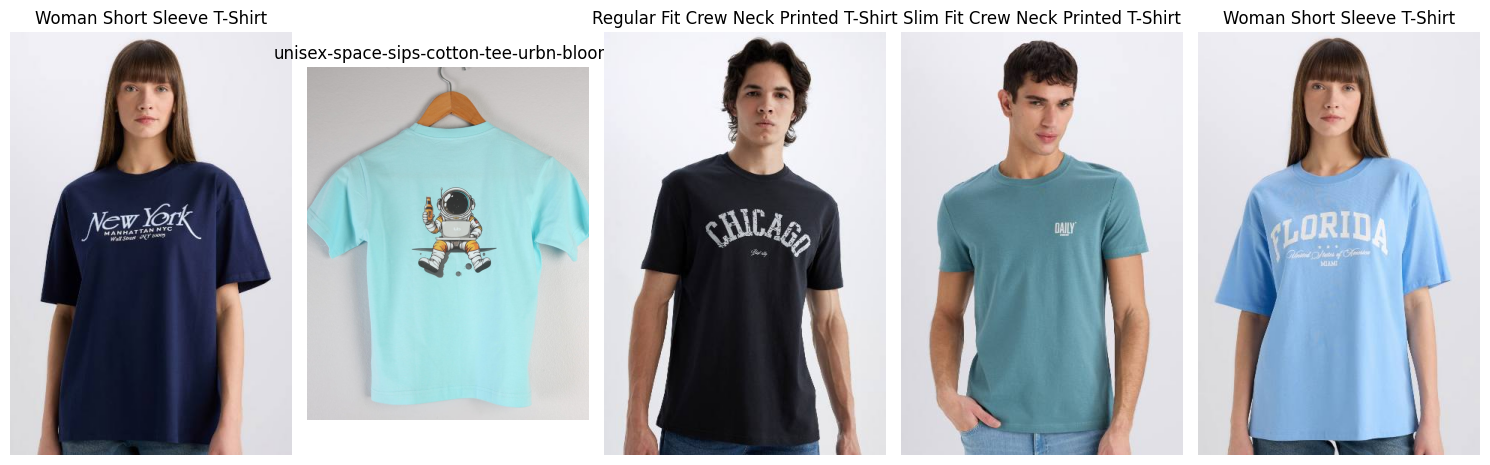

In [ ]:
# Example usage
query_image_url = "https://th.bing.com/th/id/OIP.IRXdRj61rZj5aPsAykcFKQHaI2?rs=1&pid=ImgDetMain"
similar_items = find_similar_items_from_saved(query_image_url, top_n=5)
#print(similar_items)
show_images_from_df(similar_items, title_col="p_name")


In [ ]:
# Example usage
query_image_url = "https://img.staticdj.com/44e8af37ac8954d5d26f28f5b25d45e1.jpeg"
similar_items = find_similar_items_from_saved(query_image_url, top_n=5)
print(similar_items[["p_name", "p_img", "p_link", "p_base_price"]])


Predicted category: dress
                                                p_name  \
294         Shirt Collar Poplin Long Sleeve Maxi Dress   
210                     Bodycon Satin Sleeveless Dress   
169            A Cut Shirt Collar Poplin Batwing Dress   
36   A Cut V-Neck Printed Sensual Sleeveless Maxi D...   
79               Shirt Collar Poplin Long Sleeve Dress   

                                                 p_img  \
294  https://dfcdn.defacto.com.tr/376/D2772AX_24SM_...   
210  https://dfcdn.defacto.com.tr/376/E7256AX_25SP_...   
169  https://dfcdn.defacto.com.tr/376/E7114AX_25SP_...   
36   https://dfcdn.defacto.com.tr/376/D4804AX_24HS_...   
79   https://dfcdn.defacto.com.tr/376/D4164AX_24AU_...   

                                                p_link p_base_price  
294  https://www.defacto.com//en-eg/gomlek-yaka-pop...       2699.0  
210  https://www.defacto.com//en-eg/bodycon-vucudu-...       1699.0  
169  https://www.defacto.com//en-eg/a-kesim-yuvarla...        999.

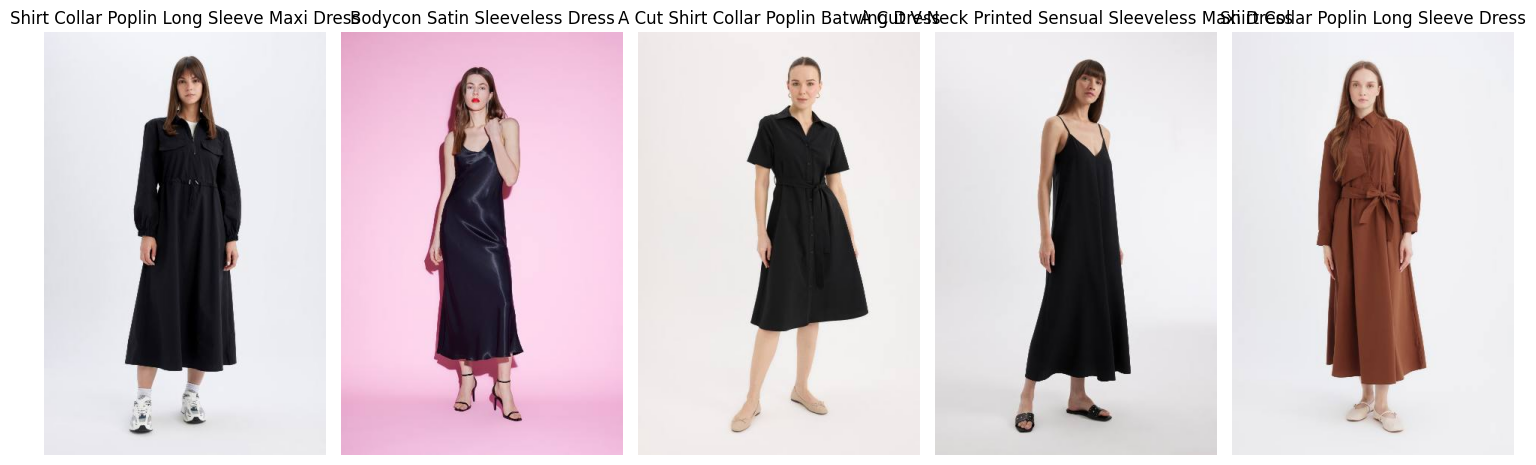

In [ ]:
show_images_from_df(similar_items, title_col="p_name")

Predicted category: shirt


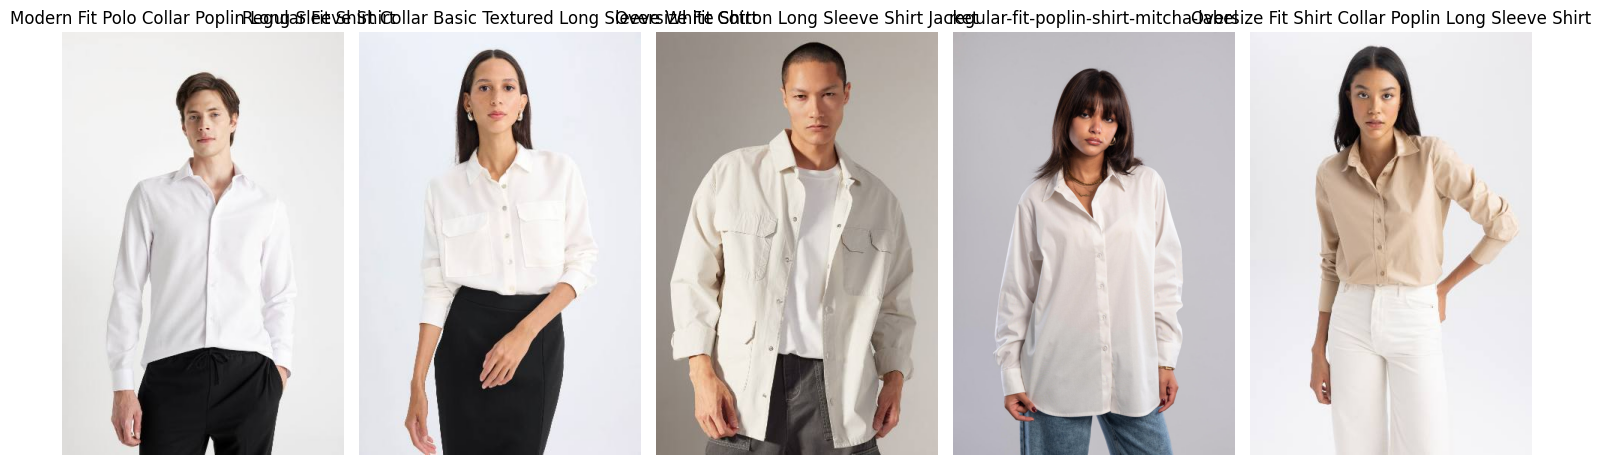

In [ ]:
# Example usage
query_image_url = "https://www.theshirtstore.co.uk/images/guide-london-chain-print-long-sleeve-mens-shirt-p3086-97125_medium.jpg"
similar_items = find_similar_items_from_saved(query_image_url, top_n=5)
#print(similar_items[["p_name", "p_img", "p_link", "p_base_price"]])
show_images_from_df(similar_items, title_col="p_name")

Predicted category: shoes


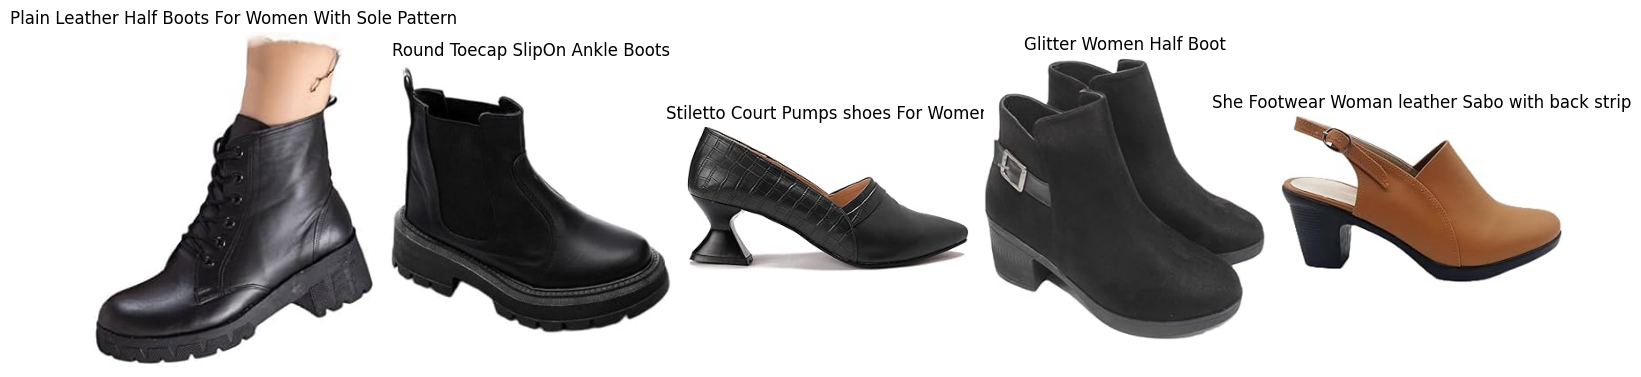

In [ ]:
# Example usage
query_image_url = "https://th.bing.com/th/id/OIP.iMwWt209BsNiNnBu3yq9JQHaHa?rs=1&pid=ImgDetMain"
similar_items = find_similar_items_from_saved(query_image_url, top_n=5)
#print(similar_items[["p_name", "p_img", "p_link", "p_base_price"]])
show_images_from_df(similar_items, title_col="p_name")

Predicted category: dress


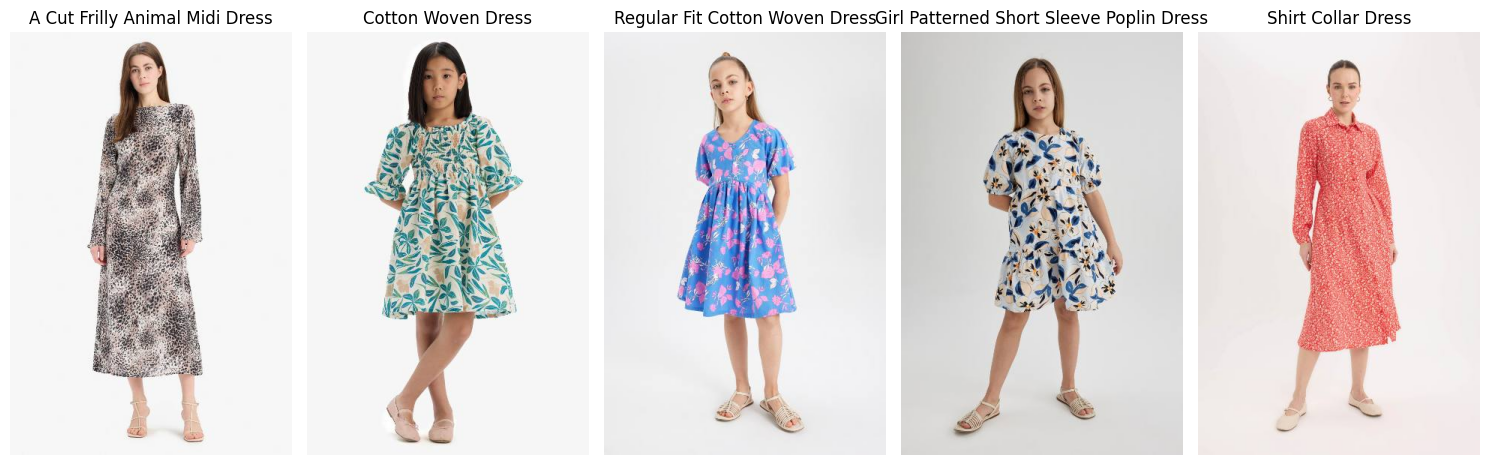

In [ ]:
# Example usage
query_image_url = "https://th.bing.com/th/id/OIP.KNAH8QXbKnz-S9KDCoQGNQHaLH?w=733&h=1100&rs=1&pid=ImgDetMain"
similar_items = find_similar_items_from_saved(query_image_url, top_n=5)
#print(similar_items[["p_name", "p_img", "p_link", "p_base_price"]])
show_images_from_df(similar_items, title_col="p_name")